transfer_learning_221027

## 한글폰트 적용
- 런타임 재시작 이후에는 별도로 재시작할 필요 없음

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (12.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

## 전이학습
- AlexNet, ResNet
- 좋은 모델들은 딥러닝 프레임워크를 통해서 이미 함수화를 제공.
- 사용자 입장 : 해당 중요 알고리즘들을 갔다 쓰면 됨.
- 가져와서 (살짝) 변형해서 현장에 맞게 적용.
- 특정한 알고리즘을 개발 시, 활용했던 이미지 데이터셋과 현장 데이터는 다름
- 현장에 맞도록 수정 보완해서 사용
- 키워드 : 파인 튜닝 (Fine Tunning)
- 주요 알고리즘 : ResNet50

## 주요 라이브러리 호출

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## ResNet
- 2015년, MS에서 개발.
- 논문 / 피인용 수
- 2015년 이전, 레이어를 어떻게 계속 늘려나갈까
  + 레이어를 늘리면 늘릴수록 성능이 좋아짐 / 문제는 연산량이 증가, 개발속도가 떨어짐
  + 잔차학습 (Residual Learning) => 지름길을 이용하면 속도가 빨라짐.

In [3]:
# 사전에 훈련된 모델 내려받기
model = ResNet50 (include_top=True,  # 기존 모델 사용할까요?
                  weights= 'imagenet',  # imageNet에 사용된 가중치
                  input_tensor=None, 
                  input_shape=None, 
                  pooling=None, 
                  classes=1000)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

- 사전 훈련된 합성곱층의 가중치를 고정
- 밀집층 레이어를 추가
- Fine Tunning의 영역

In [4]:
model.trainable=False

# 성능을 올린다?
# 머신러닝, Feature 추출, Feature를 좀 더 확인 (통계 / 도메인 지식)
# 딥러닝, 모델을 바꾸거나, Fine Tunning = 각 사용자가 레이어를 추가
model = Sequential([model, Dense(2,activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 25,638,714
Trainable params: 2,002
Non-trainable params: 25,636,712
_________________________________________________________________


- 모델을 컴파일한다.

In [5]:
model.compile (loss = 'binary_crossentropy', 
               optimizer='adam',
               metrics=['accuracy'])

## ImageDataGenerator 클래스
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- 이미지 데이터를 생성한다.
  + (쓸만한) 주어진 데이터의 크기는 현장에서는 매우 적다.
  + 가상으로 시뮬레이션을 하면서 데이터를 무작위로 생성할 필요가 있다.
- 더 많은 데이터 생성됐다.
  + 장점 : 정확도 상승 > 기존 데이터, 과대적합 방지
  + 단점 : 많아진 데이터 만큼 모델 개발 속도는 저하, 시간이 오래 걸린다.

## 구글 드라이브 연동

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
BATCH_SIZE =32
image_height = 224
image_width = 224

# 경로
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/산대특/deeplearning/ch05/data/catanddog"
train_dir = DATA_PATH+'/train'
valid_dir = DATA_PATH+"/validation"

In [8]:
train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed = 1,
    shuffle=True,
    class_mode = 'categorical'
)

valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed = 7,
    shuffle=True,
    class_mode = 'categorical'
)

history = model.fit(train_generator,
                    epochs=10,
                    validation_data= valid_generator,
                    verbose=2)

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Epoch 1/10
13/13 - 99s - loss: 0.6931 - accuracy: 0.5299 - val_loss: 0.6933 - val_accuracy: 0.4694 - 99s/epoch - 8s/step
Epoch 2/10
13/13 - 88s - loss: 0.6932 - accuracy: 0.4519 - val_loss: 0.6933 - val_accuracy: 0.3878 - 88s/epoch - 7s/step
Epoch 3/10
13/13 - 87s - loss: 0.6932 - accuracy: 0.4494 - val_loss: 0.6933 - val_accuracy: 0.4898 - 87s/epoch - 7s/step
Epoch 4/10
13/13 - 87s - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6933 - val_accuracy: 0.5000 - 87s/epoch - 7s/step
Epoch 5/10
13/13 - 87s - loss: 0.6929 - accuracy: 0.5273 - val_loss: 0.6933 - val_accuracy: 0.5000 - 87s/epoch - 7s/step
Epoch 6/10
13/13 - 90s - loss: 0.6928 - accuracy: 0.5273 - val_loss: 0.6933 - val_accuracy: 0.5000 - 90s/epoch - 7s/step
Epoch 7/10
13/13 - 87s - loss: 0.6927 - accuracy: 0.5273 - val_loss: 0.6933 - val_accuracy: 0.5000 - 87s/epoch - 7s/step
Epoch 8/10
13/13 - 87s - loss: 0.6926 - accuracy: 0.5273 - val_loss: 0.6

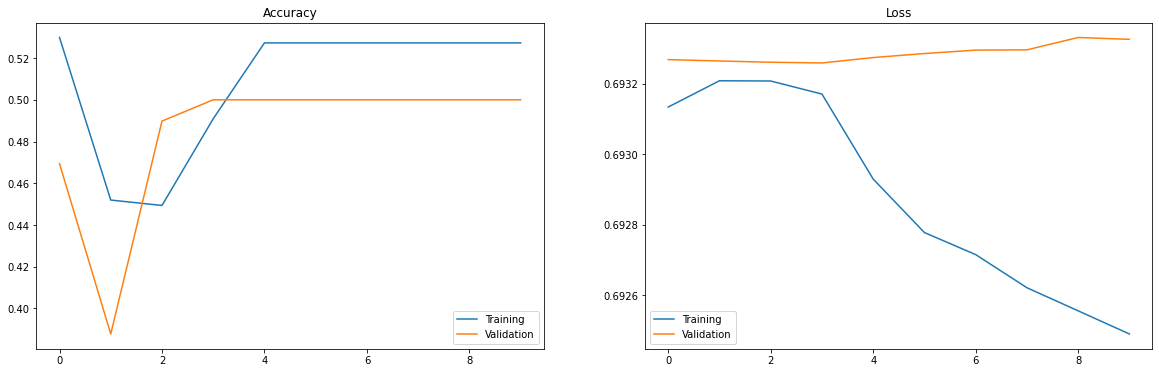

In [9]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, ax = plt.subplots(nrows=1,
                       ncols=2,
                       figsize=(20,6))
ax[0].plot(epochs, accuracy, label='Training')
ax[0].plot(epochs, val_accuracy, label='Validation')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, label='Training')
ax[1].plot(epochs, val_loss, label='Validation')
ax[1].set_title('Loss')
ax[1].legend()


plt.show()

## 훈련된 모델의 예측

1/1 [==============================] - 7s 7s/step


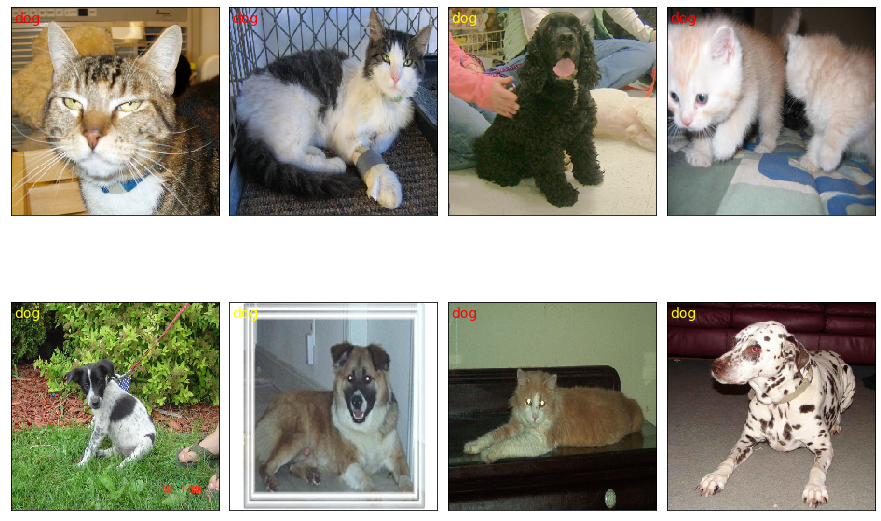

In [10]:
class_names = ['cat', 'dog']
validation, label_batch  = next(iter(valid_generator))
prediction_values = model.predict(validation)
prediction_values = np.argmax(prediction_values, axis=1)

fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(validation[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[prediction_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

## 텐서플로 허브 사용
- https://www.tensorflow.org/hub?hl=ko

In [11]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
                   input_shape=(224, 224, 3),
                   trainable=False),  
    tf.keras.layers.Dense(2, activation='softmax')
])

In [12]:
model.compile (loss = 'binary_crossentropy', 
               optimizer='adam',
               metrics=['accuracy'])

In [13]:
train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed = 1,
    shuffle=True,
    class_mode = 'categorical'
)

valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid.flow_from_directory(
    valid_dir,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    seed = 7,
    shuffle=True,
    class_mode = 'categorical'
)

history = model.fit(train_generator,
                    epochs=10,
                    validation_data= valid_generator,
                    verbose=2)

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Epoch 1/10
13/13 - 229s - loss: 0.6454 - accuracy: 0.7662 - val_loss: 0.2640 - val_accuracy: 0.9490 - 229s/epoch - 18s/step
Epoch 2/10
13/13 - 211s - loss: 0.1868 - accuracy: 0.9532 - val_loss: 0.1094 - val_accuracy: 0.9796 - 211s/epoch - 16s/step
Epoch 3/10
13/13 - 214s - loss: 0.0950 - accuracy: 0.9714 - val_loss: 0.0745 - val_accuracy: 0.9796 - 214s/epoch - 16s/step
Epoch 4/10
13/13 - 218s - loss: 0.0671 - accuracy: 0.9792 - val_loss: 0.0612 - val_accuracy: 0.9898 - 218s/epoch - 17s/step
Epoch 5/10
13/13 - 217s - loss: 0.0545 - accuracy: 0.9870 - val_loss: 0.0536 - val_accuracy: 0.9898 - 217s/epoch - 17s/step
Epoch 6/10
13/13 - 217s - loss: 0.0517 - accuracy: 0.9844 - val_loss: 0.0504 - val_accuracy: 0.9898 - 217s/epoch - 17s/step
Epoch 7/10
13/13 - 218s - loss: 0.0386 - accuracy: 0.9896 - val_loss: 0.0454 - val_accuracy: 0.9898 - 218s/epoch - 17s/step
Epoch 8/10
13/13 - 215s - loss: 0.0352 - accuracy: 

## 설명가능한 머신러닝
- 교재 190p. 설명 가능한 CNN

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

- Sequential API를 이용해서 모델을 만든다.
- 모델은 합성곱층과 최대 풀링층 쌍을 네개 쌓는다.

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(100,100,3), activation='relu', kernel_size=(5,5), filters=32),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(activation='relu', kernel_size=(5,5), filters=64),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(activation='relu', kernel_size=(5,5), filters=64),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(activation='relu', kernel_size=(5,5), filters=64),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)        

- 특성 맵 정의
  + 합성곱층 입력 이미지의 필터를 연산하여 얻은 결과

In [16]:
ins = model.inputs
outs = model.layers[0].output
feature_map = Model(inputs=ins, outputs=outs)
feature_map.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        2432      
                                                                 
Total params: 2,432
Trainable params: 2,432
Non-trainable params: 0
_________________________________________________________________


## 구글 드라이브 연동

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


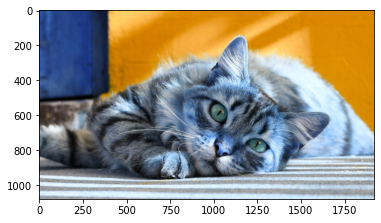

In [22]:
CAT_IMG_PATH ="/content/drive/MyDrive/Colab Notebooks/산대특/deeplearning/ch05/data/cat.jpg"
img = cv2.imread(CAT_IMG_PATH)
plt.imshow(img)

(1, 100, 100, 3)
1/1 [==============================] - 0s 84ms/step
(1, 96, 96, 32)


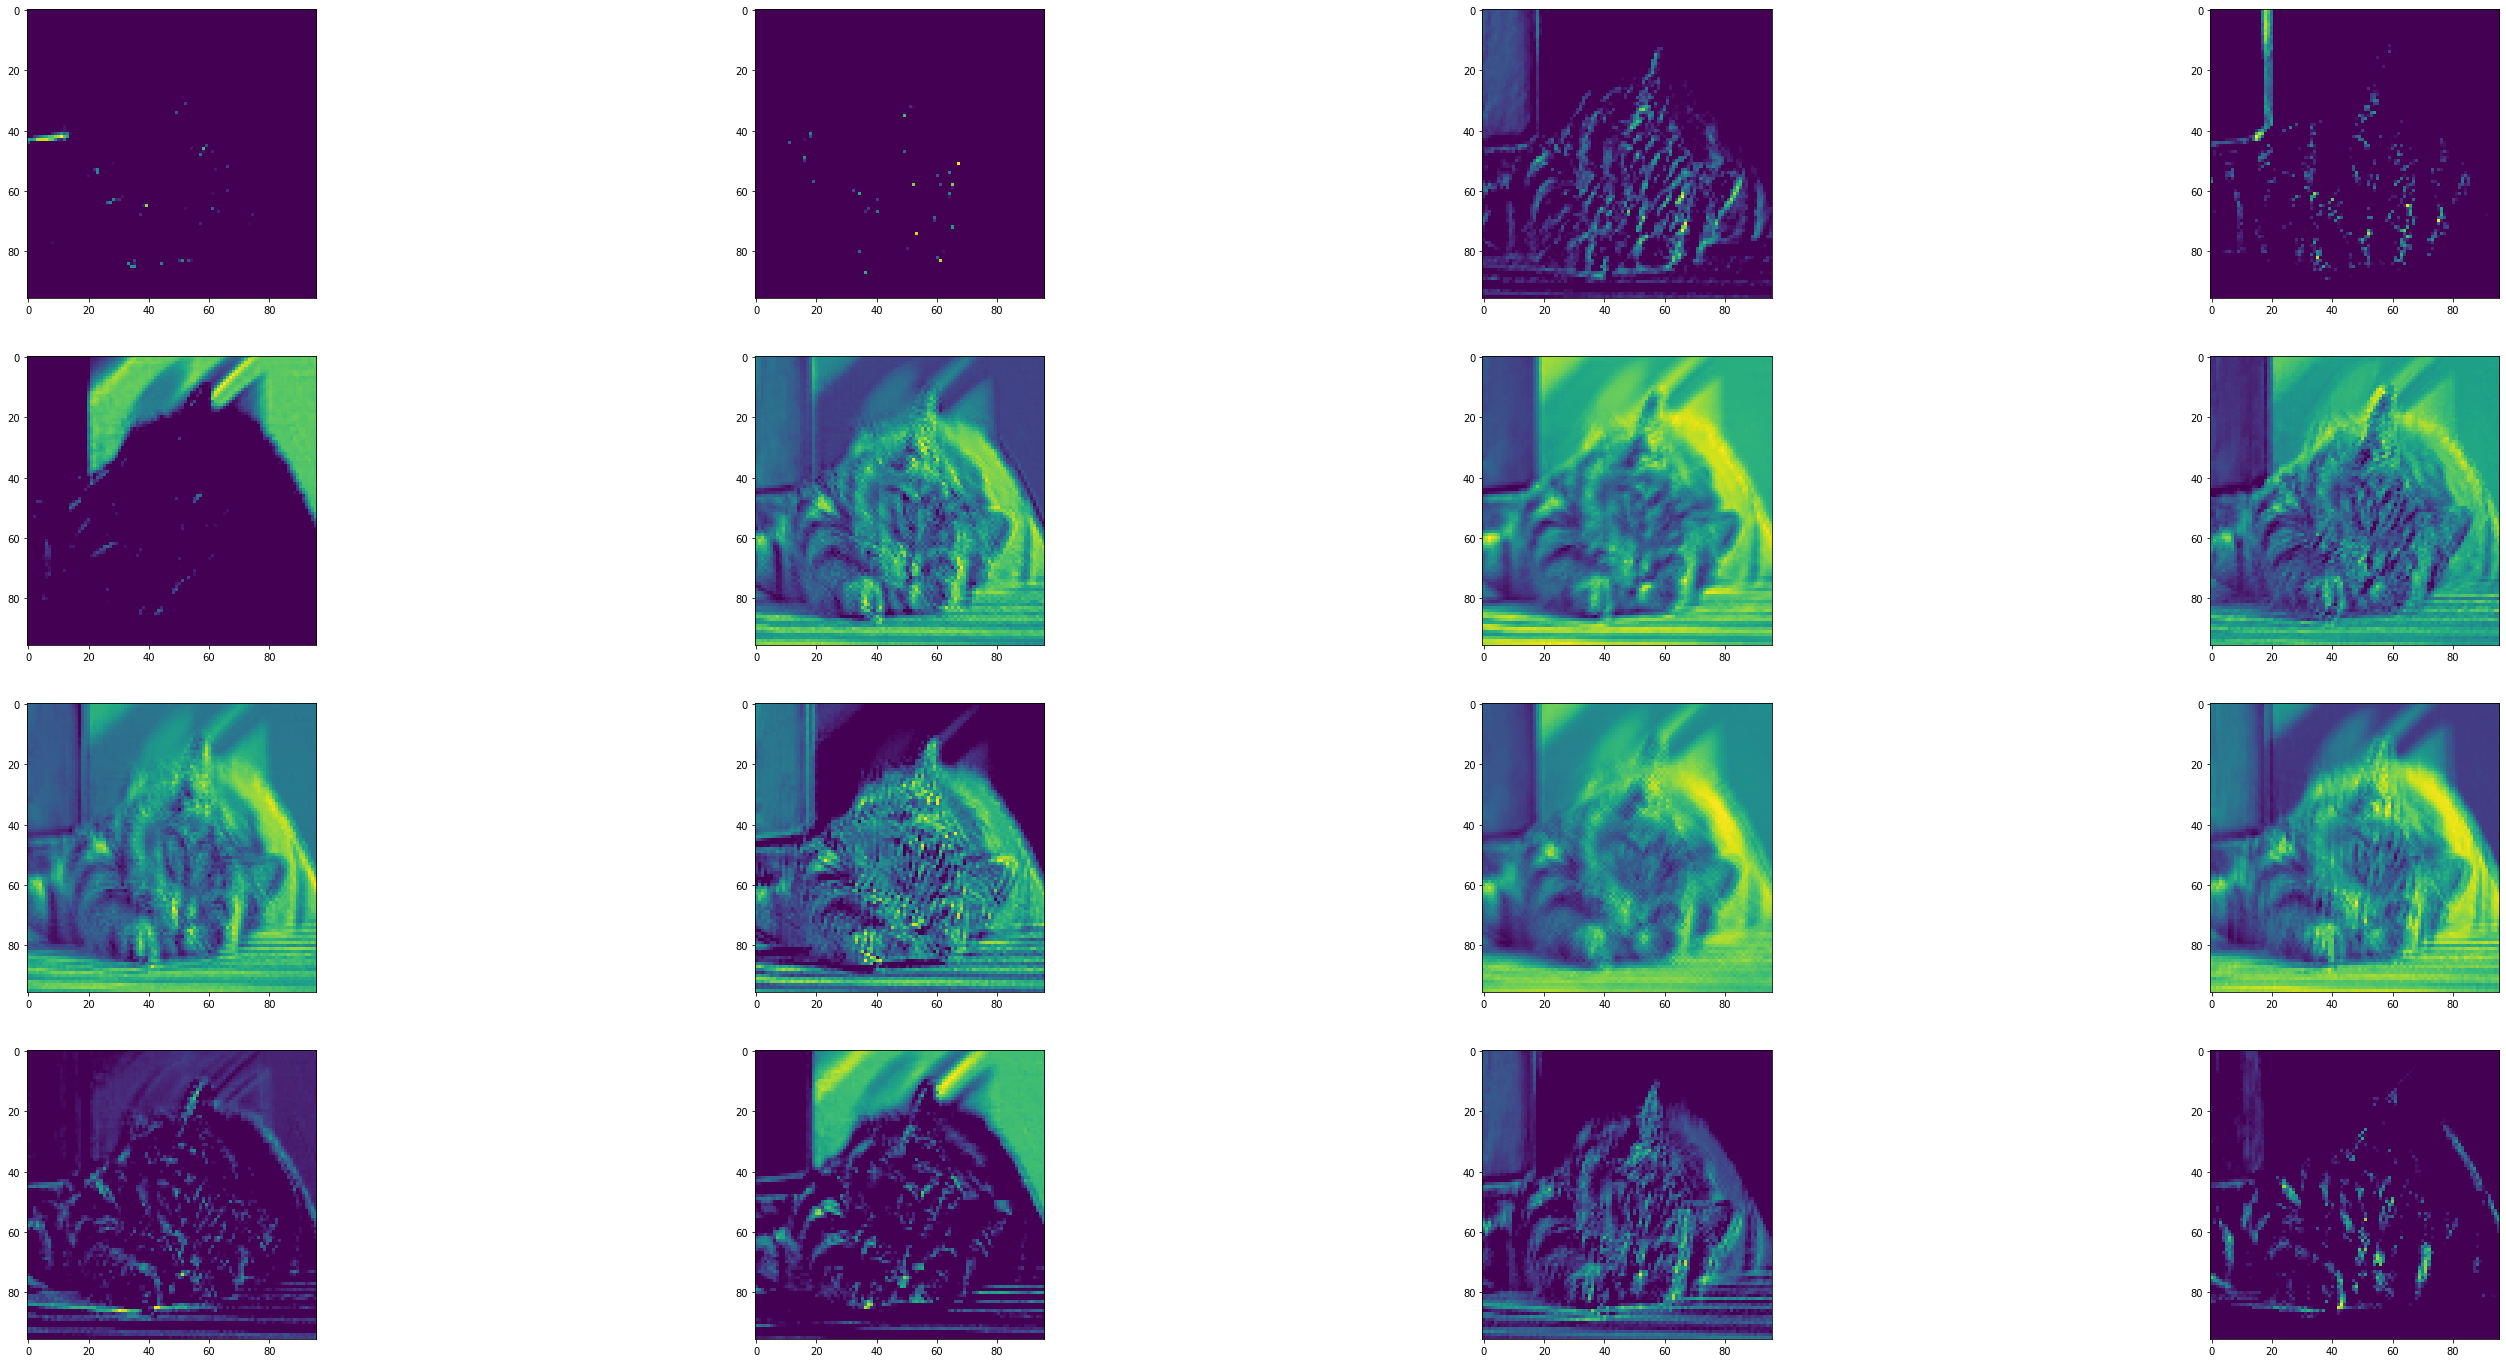

In [20]:
img=cv2.resize(img,(100,100))               
input_img= np.expand_dims(img, axis=0)      
print(input_img.shape)                      
feature=feature_map.predict(input_img)       
print(feature.shape)                            
fig= plt.figure(figsize=(50,50))
for i in range(16):
    ax=fig.add_subplot(8,4,i+1)
    ax.imshow(feature[0,:,:,i])  

1/1 [==============================] - 0s 72ms/step


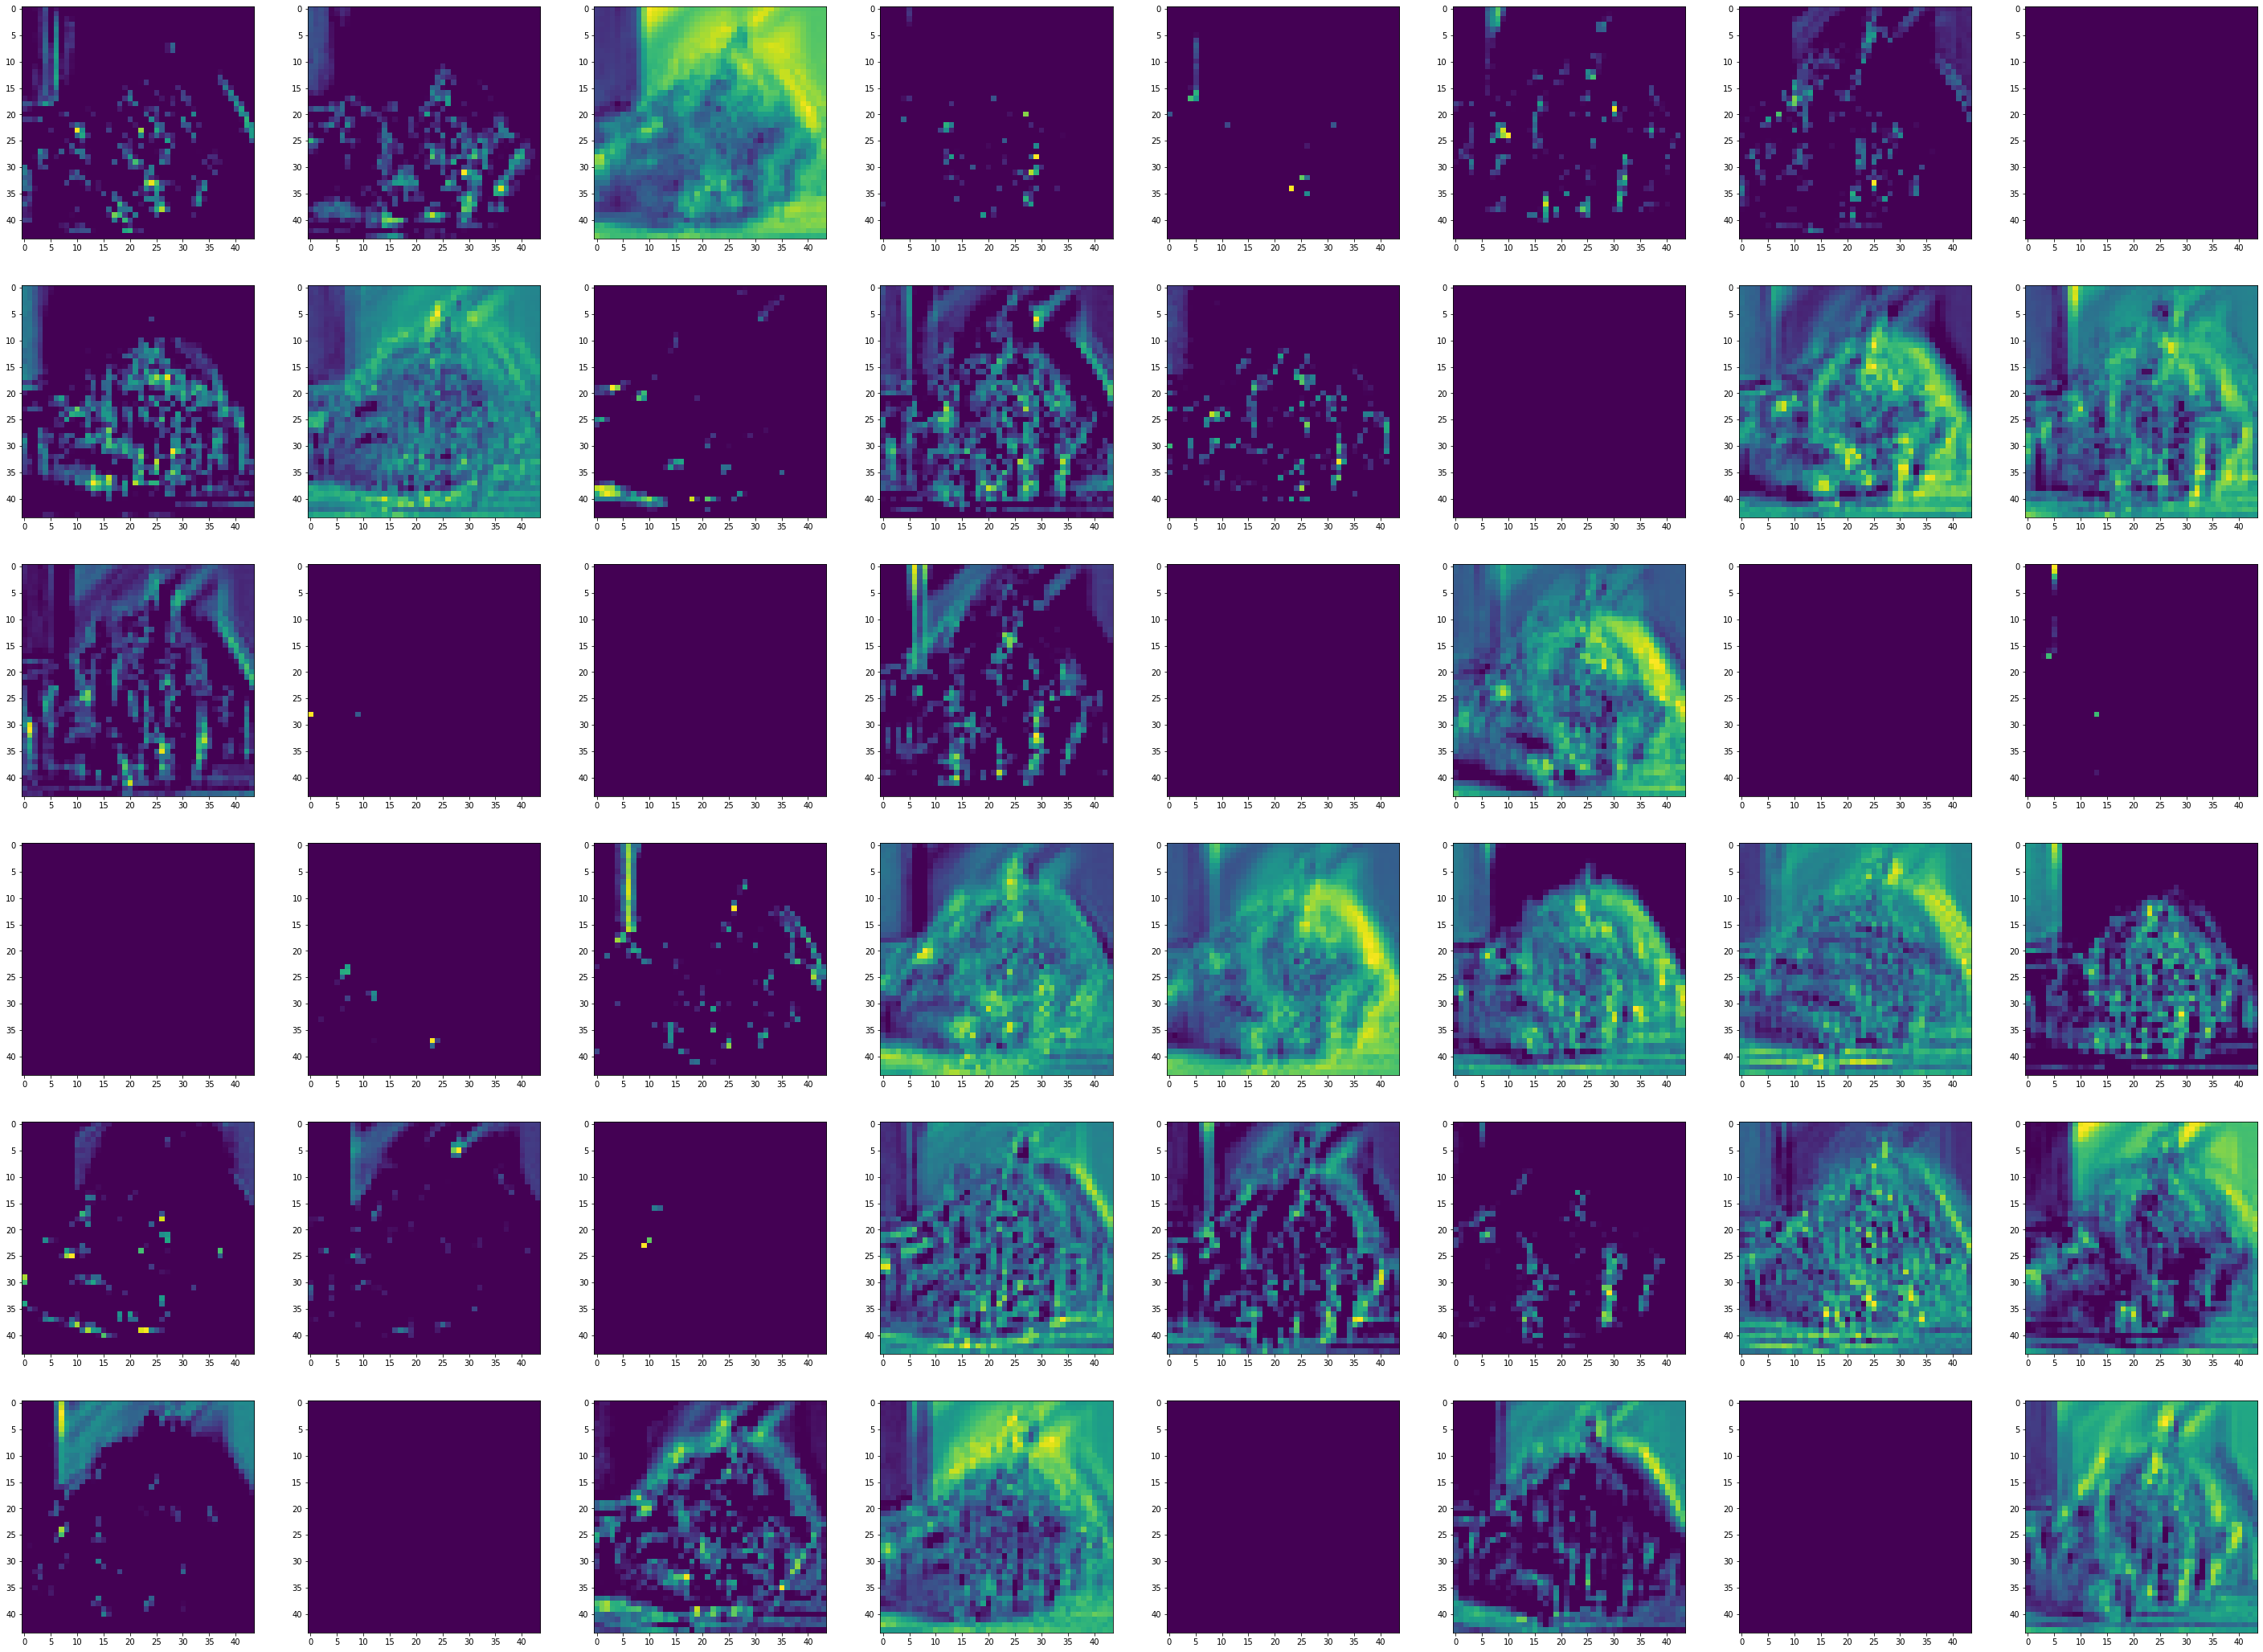

In [23]:
ins= model.inputs 
outs= model.layers[2].output  
feature_map= Model(inputs= ins, outputs= outs)  
img=cv2.imread(CAT_IMG_PATH)                   
img=cv2.resize(img,(100,100))               
input_img= np.expand_dims(img, axis=0)   

feature=feature_map.predict(input_img)        
fig= plt.figure(figsize=(50,50))
for i in range(48):
    ax=fig.add_subplot(8,8,i+1)
    ax.imshow(feature[0,:,:,i])

1/1 [==============================] - 0s 280ms/step


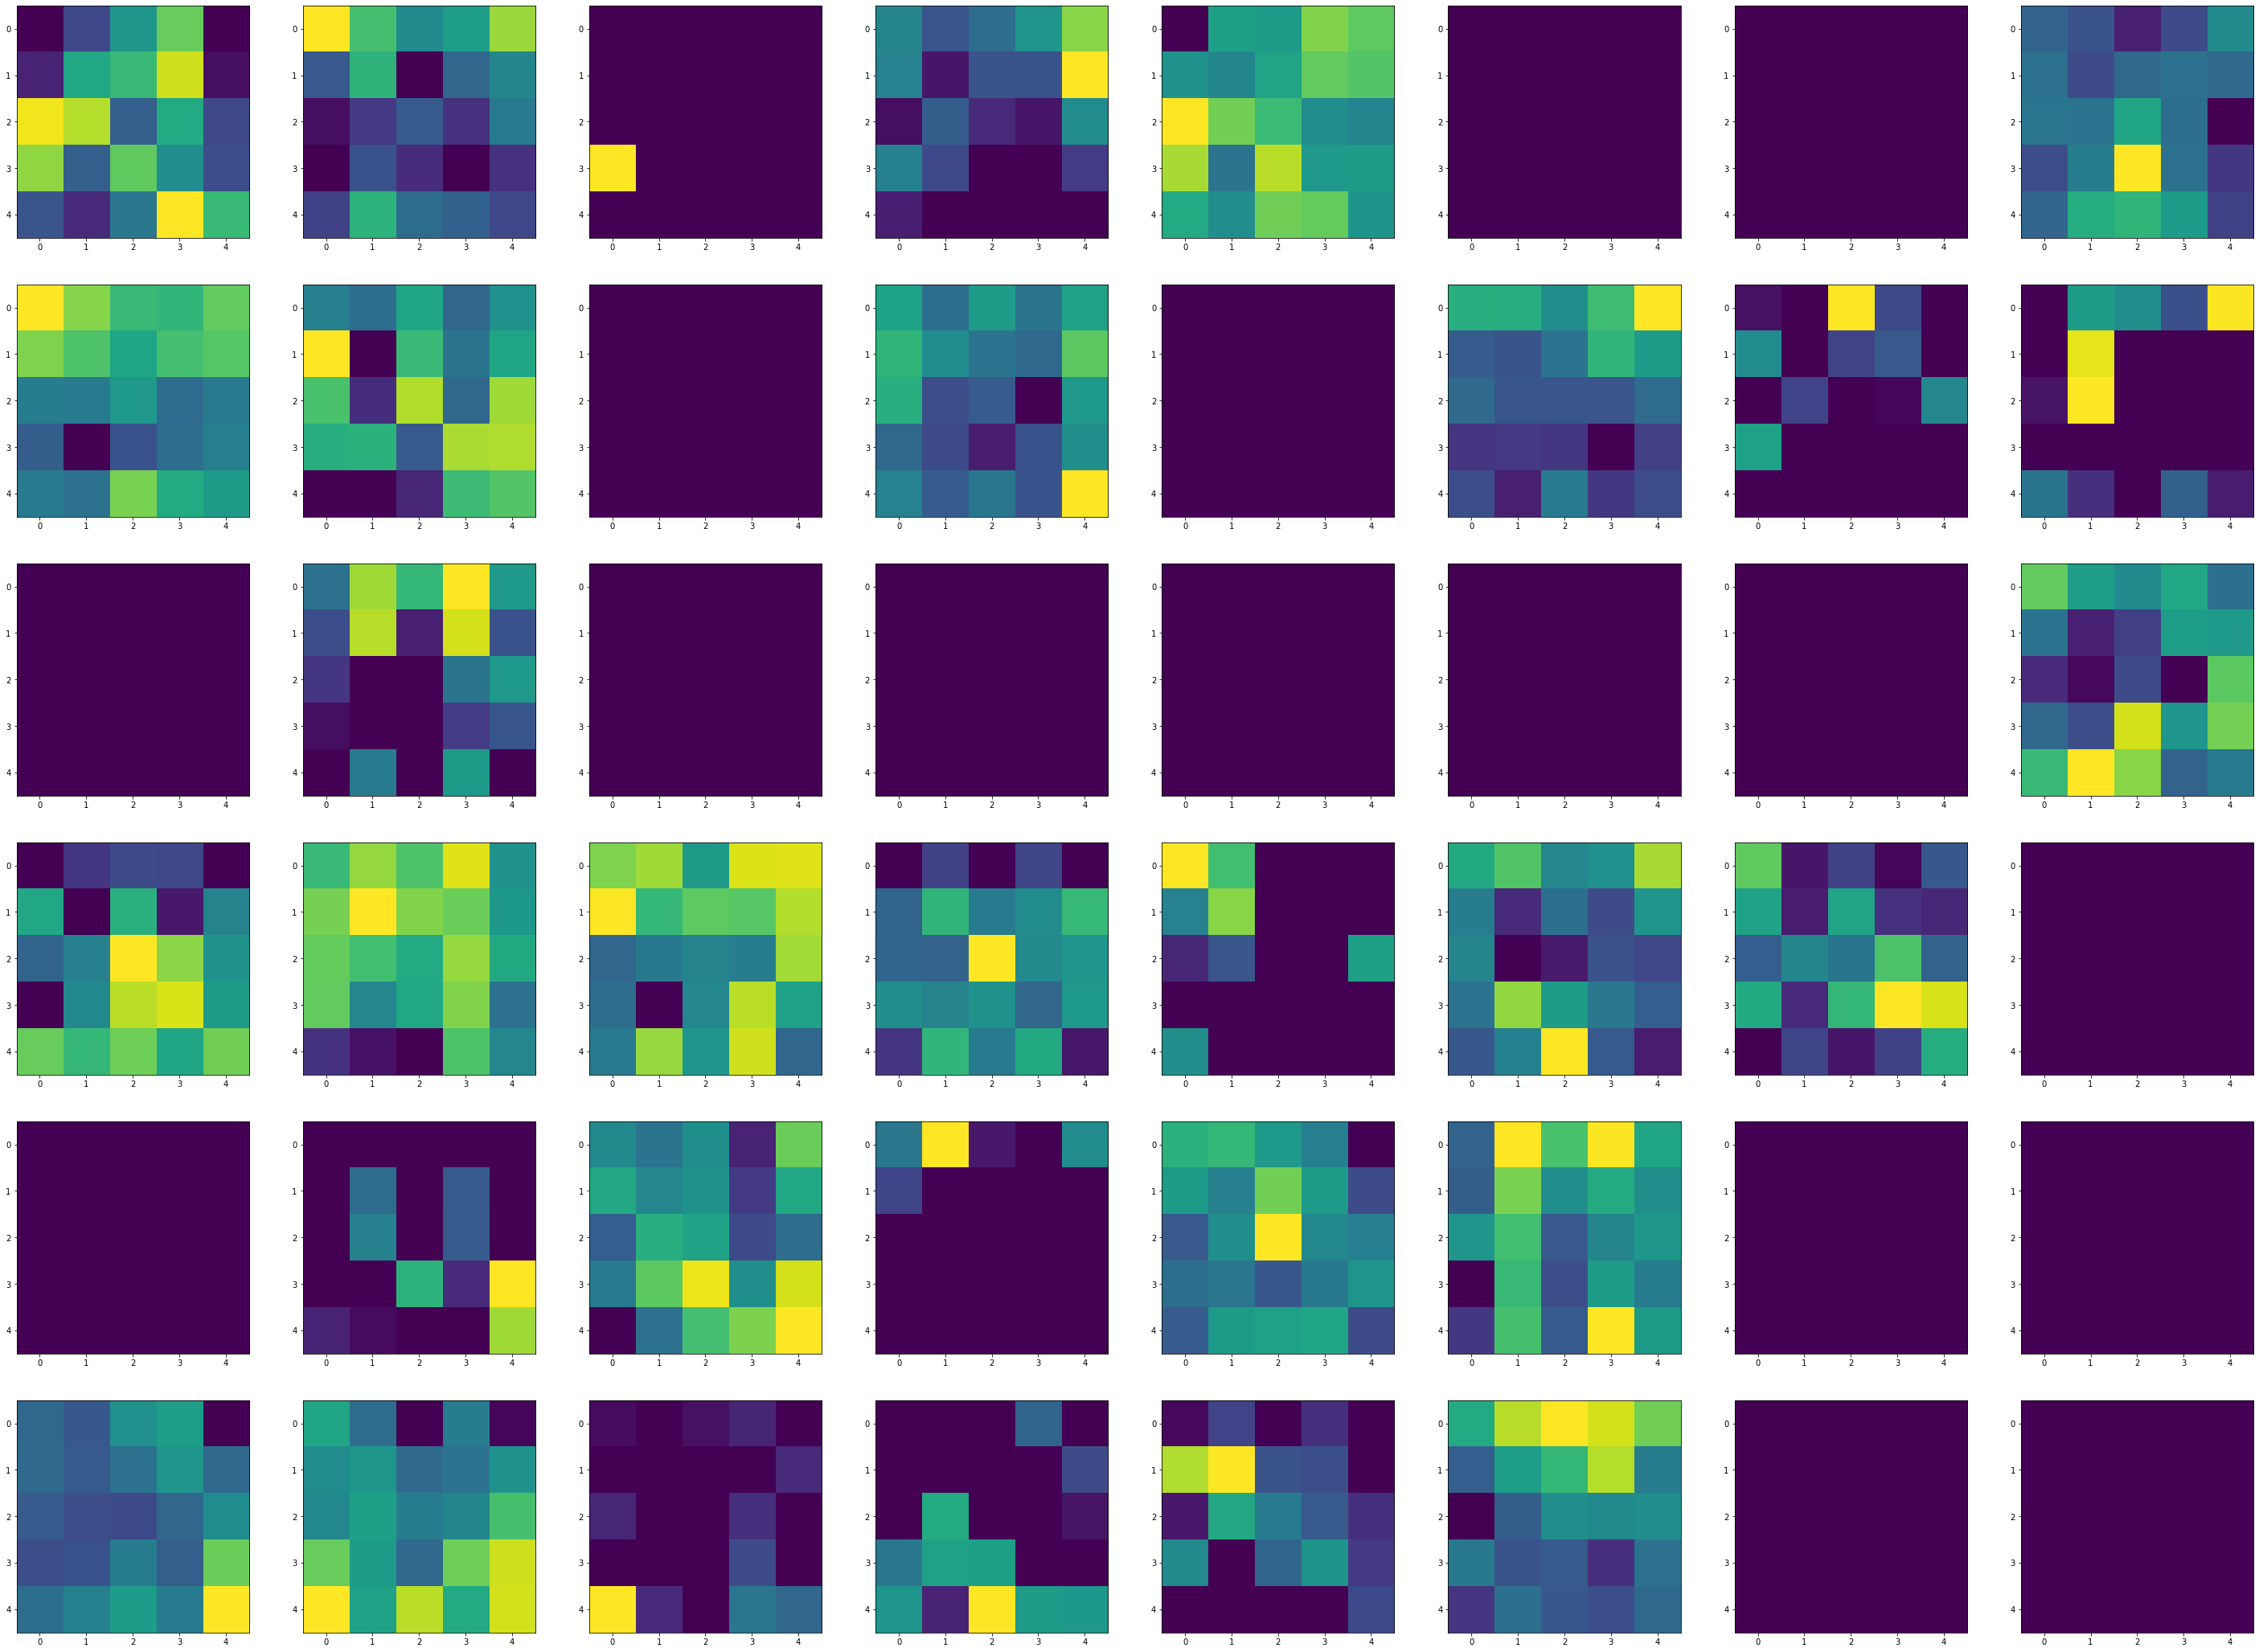

In [25]:
ins = model.inputs
outs = model.layers[6].output
feature_map = Model(inputs=ins, outputs=outs)

img = cv2.imread(CAT_IMG_PATH)
img = cv2.resize(img, (100,100))
input_img = np.expand_dims(img, axis=0)

feature = feature_map.predict(input_img)
fig = plt.figure(figsize=(50,50))
for i in range(48) :
  ax = fig.add_subplot(8,8,i+1)
  ax.imshow(feature[0,:,:,i])